## Visualizing and augmenting GTA Data


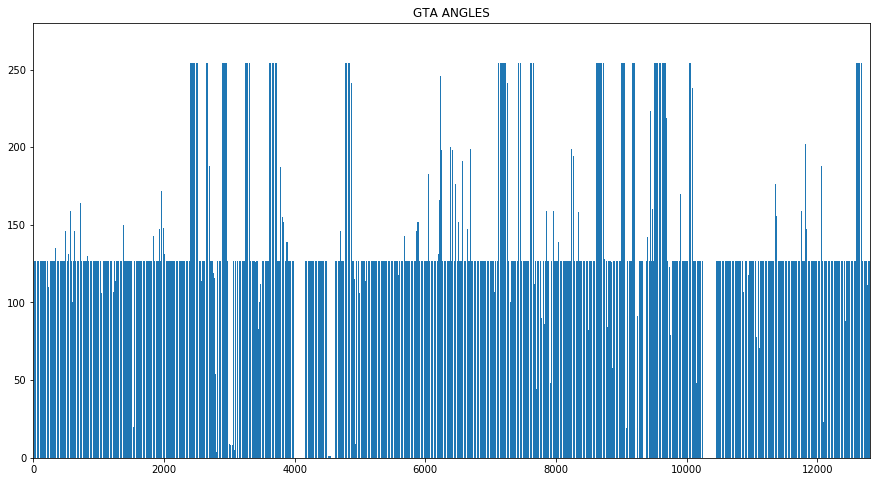

In [24]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

gta_data = pd.read_csv(os.path.join('gtadata','training.csv'))
# Data columns' names are: center,left,right,steering,throttle,brake,speed

# Visualizations will be shown inline in the notebook.
%matplotlib inline

plt.figure(figsize=(15,8))
plt.bar(gta_data.angle.index,gta_data.angle.values)
plt.ylim(0, 280)
plt.xlim(0, len(gta_data.angle.index))
plt.title('GTA ANGLES')

In [25]:
print('Number of images in GTA data: %d' %len(gta_data.angle.index))

Number of images in GTA data: 12808


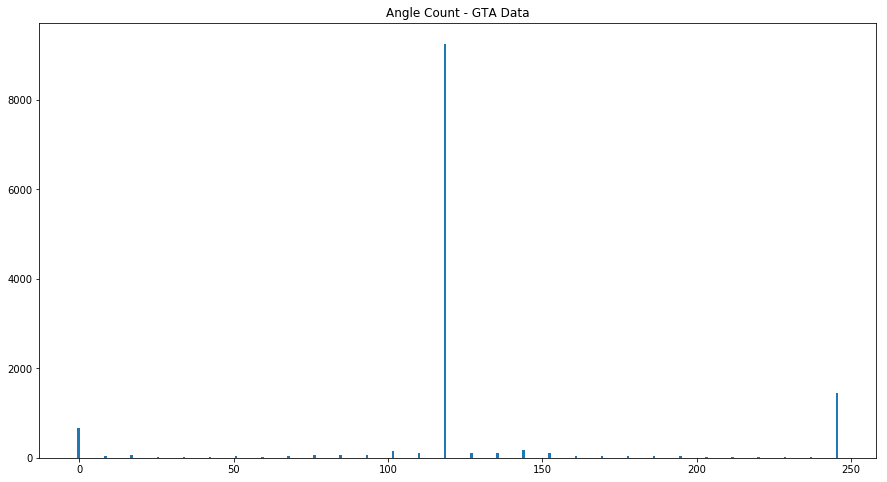

In [22]:
plt.figure(figsize=(15,5))
histogram_gta_data = gta_data.angle.value_counts(bins=30)
plt.bar(histogram_gta_data.index,histogram_gta_data.values)
plt.title('Angle Count - GTA Data')

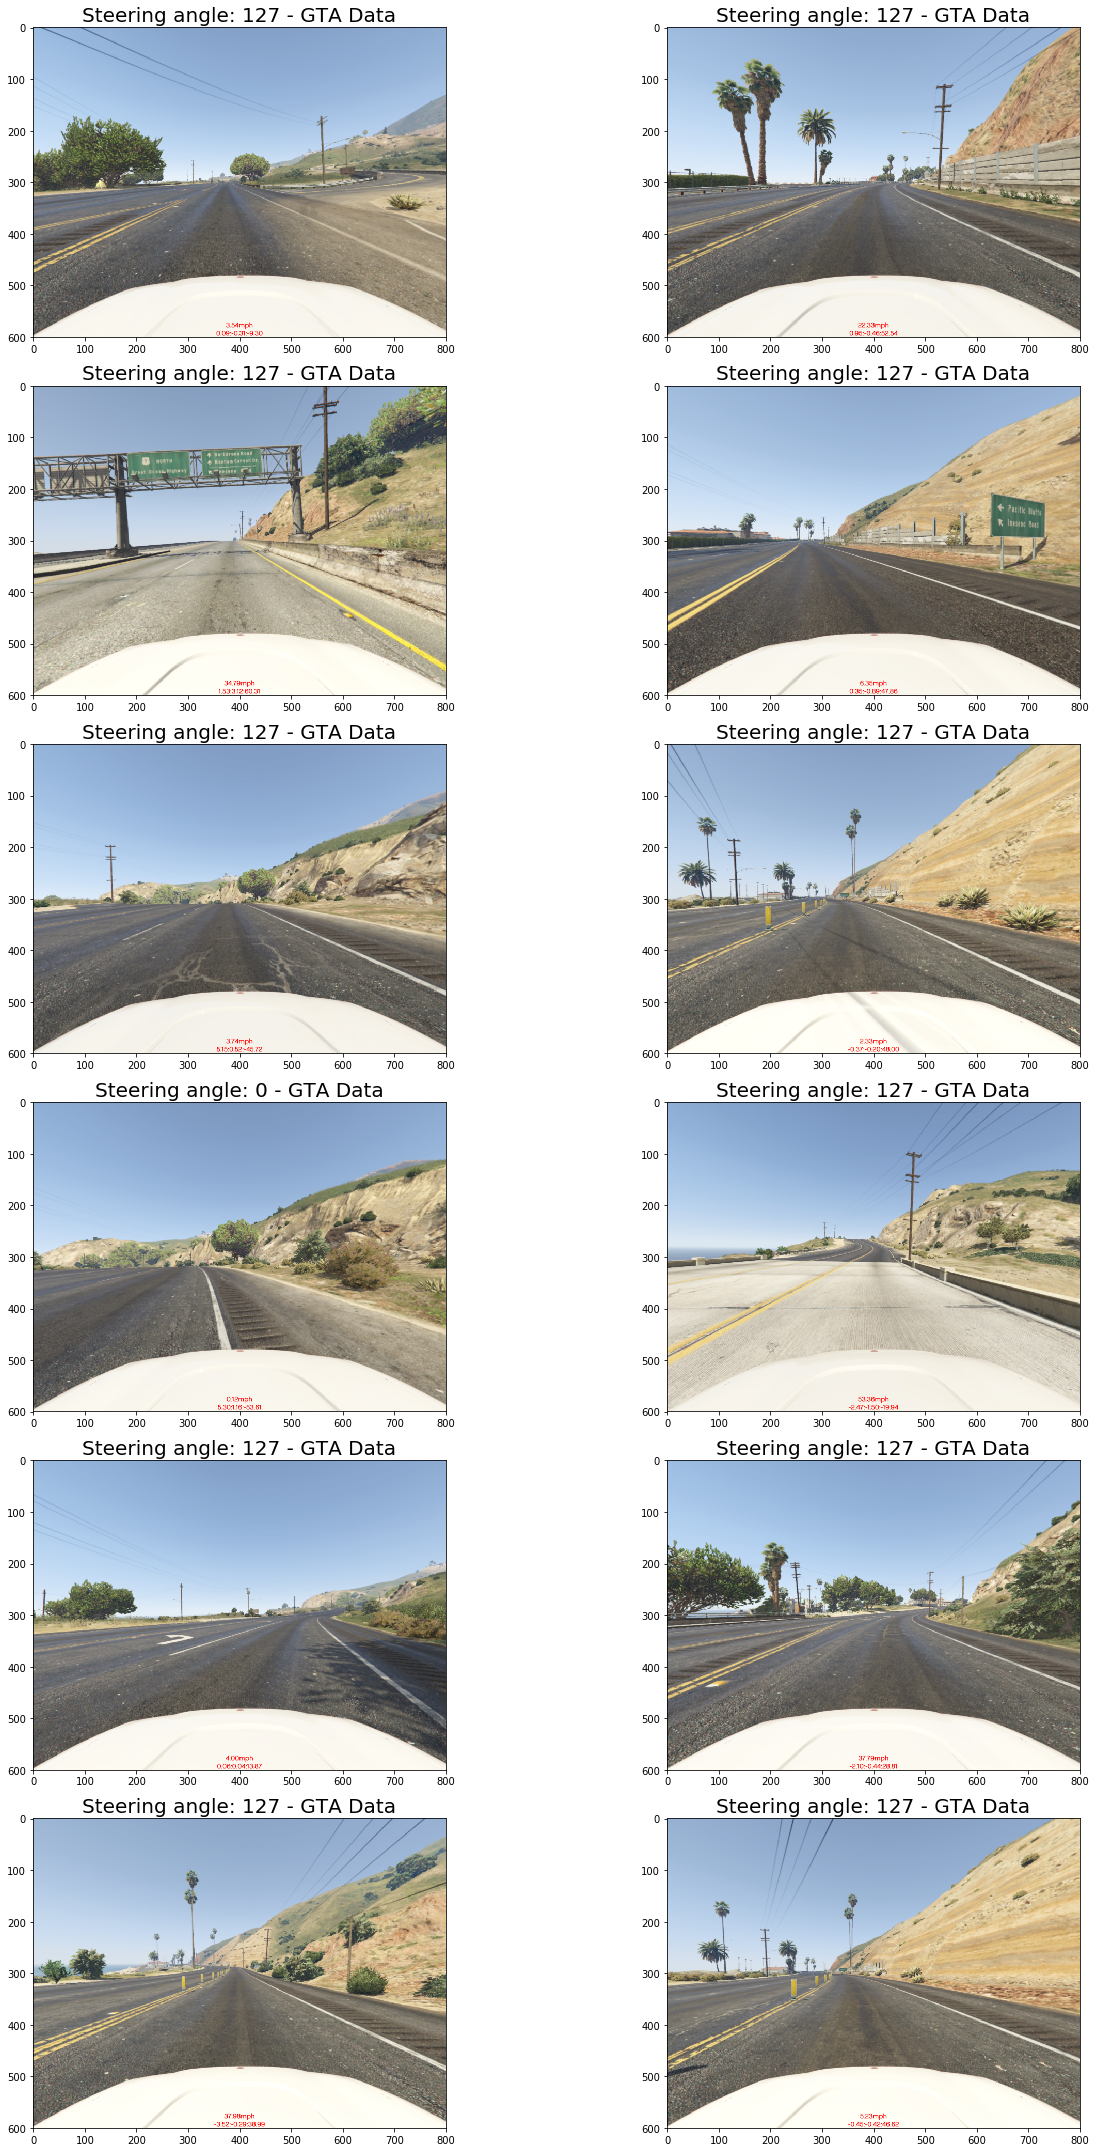

In [29]:

fig3 = plt.figure(figsize=(20, 30))
gs = gridspec.GridSpec(6, 2)

for g in gs:
    ax = fig3.add_subplot(g)
    index = np.random.randint(len(gta_data))
    temp = gta_data.center.iloc[index].strip()
    image = mpimg.imread(temp)
    ax.set_title('Steering angle: %s - GTA Data'%(gta_data.angle[index]),fontsize=20)
    ax.imshow(image)
    
gs.tight_layout(fig3)

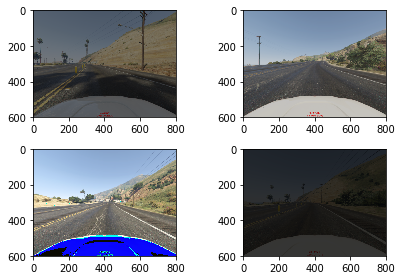

In [31]:
def change_brightness(image):
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    brightness = 0.20 + np.random.uniform()
    hsv_image[:,:,2] = hsv_image[:,:,2]* brightness
    return cv2.cvtColor(hsv_image,cv2.COLOR_HSV2RGB)

fig4 = plt.figure()
gs = gridspec.GridSpec(2, 2)

for g in gs:
    index = np.random.randint(len(gta_data))
    temp = gta_data.center.iloc[index].strip()
    image = mpimg.imread(temp)
    ax = fig4.add_subplot(g)
    new_bright_img = change_brightness(image)
    ax.imshow(new_bright_img)

gs.tight_layout(fig4)


0.8716340238593562
0.7043454889967551
1.2329175016018392
1.1414460600894711


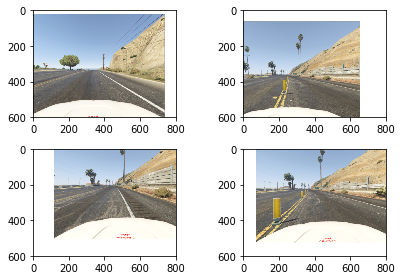

In [34]:
X_RANGE = 300
Y_RANGE = 200
ANGLE_RANGE = .3
def x_y_translation(image,angle=0.0):
    x_translation = (X_RANGE * np.random.uniform()) - (X_RANGE * 0.5)
    y_translation = (Y_RANGE * np.random.uniform()) - (Y_RANGE * 0.5)
    # Translation Matrix
    # http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    # M is the translation Matrix
    # M = np.float32([[1,0,X],[0,1,Y]])
    M = np.float32([[1,0,x_translation],[0,1,y_translation]])
    # Modify the angle for x, given input
    rows,cols,channels = image.shape
    translated_image = cv2.warpAffine(image,M,(cols,rows))
    new_angle = angle + ((x_translation/X_RANGE)*2)*ANGLE_RANGE
    return translated_image,new_angle

fig5 = plt.figure()
gs = gridspec.GridSpec(2, 2)

for g in gs:
    index = np.random.randint(len(gta_data))
    temp = gta_data.center.iloc[index].strip()
    image = mpimg.imread(temp)
    ax = fig5.add_subplot(g)
    new_translated_image, new_angle = x_y_translation(image,1.0)
    print(new_angle)
    ax.imshow(new_translated_image)
    
gs.tight_layout(fig5)


500 290 260 540 0 800
500 290 260 540 0 800
500 290 260 540 0 800
500 290 260 540 0 800


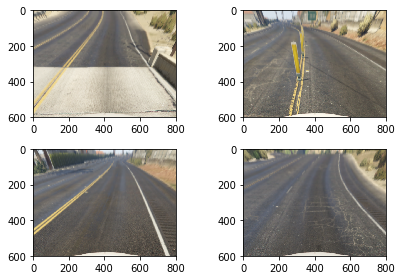

In [59]:
def warp_image(image, src, dst, image_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv

def get_roi_transformed(image):
    image_size = image.shape
    roi_y_bottom = int(image_size[0]-100)
    roi_y_top = 290# np.uint(image_size[0]/1.5)
    roi_center_x = np.uint(image_size[1]/2)
    roi_x_top_left = int(roi_center_x - .35*roi_center_x)
    roi_x_top_right = int(roi_center_x + .35*roi_center_x)
    roi_x_bottom_left = 0
    roi_x_bottom_right = int(image_size[1])
    print(roi_y_bottom,roi_y_top,roi_x_top_left,roi_x_top_right,roi_x_bottom_left,roi_x_bottom_right)
    # print(image_size,roi_y_bottom,roi_y_top,roi_center_x,roi_x_top_left,roi_x_top_right,roi_x_bottom_left,roi_x_bottom_right)
    src = np.float32([[roi_x_bottom_left,roi_y_bottom],[roi_x_bottom_right,roi_y_bottom],[roi_x_top_right,roi_y_top],[roi_x_top_left,roi_y_top]])
    dst = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],[image_size[1],0],[0,0]])
    warped_image, M_warp, Minv_warp = warp_image(image,src,dst,(image_size[1],image_size[0]))
    return warped_image, M_warp, Minv_warp

fig6 = plt.figure()
gs = gridspec.GridSpec(2, 2)

for g in gs:
    index = np.random.randint(len(gta_data))
    temp = gta_data.center.iloc[index].strip()
    image = mpimg.imread(temp)
    ax = fig6.add_subplot(g)
    roi_image, M, Minv = get_roi_transformed(image)
    ax.imshow(roi_image)

gs.tight_layout(fig6)

600
600
600
600


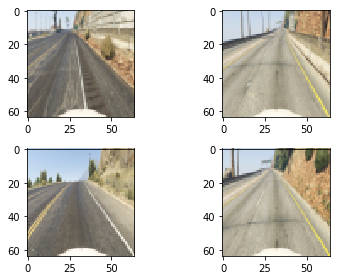

In [43]:
def crop_and_resize(image):
    cropped_image = image[250:500,:,:]#50:300
    # cv2.INTER_AREA for shrinking and cv2.INTER_CUBIC & cv2.INTER_LINEAR for zooming
    resized_image = cv2.resize(cropped_image,(64,64),interpolation=cv2.INTER_AREA)
    #height, width = img.shape[:2]
    return resized_image
    #return np.resize(resized_image,(1,64,64,3))
    
fig7 = plt.figure()
gs = gridspec.GridSpec(2, 2)

for g in gs:
    index = np.random.randint(len(gta_data))
    temp = gta_data.center.iloc[index].strip()
    image = mpimg.imread(temp)
    print(len(image))
    ax = fig7.add_subplot(g)
    cropped_and_resized_img = crop_and_resize(image)
    ax.imshow(cropped_and_resized_img)

gs.tight_layout(fig7)
